# <center>Serving Coffee in Toronto</center>

### <center>A report on neighborhoods of Toronto</center>

<br>

### Importing libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line to install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


In [2]:
#installing and importing folium
!pip install folium
import folium # map rendering library

     |████████████████████████████████| 102kB 9.7MB/s eta 0:00:01


## Part 1: Data Wrangling

### Importing Dataset

In [3]:
#importing data
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_bf0283df078c4bb1b70c50e335ee185d = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='cXY4F0nsVb4BXX5mbyxPOYApfjXAGHJAntBI3OnPK_qi',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_bf0283df078c4bb1b70c50e335ee185d.get_object(Bucket='ibmcourseracapstone-donotdelete-pr-9eti10pmn3m9za',Key='wellbeing_toronto.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

tor_df = pd.read_csv(body)
tor_df.head(7)

,Neighbourhood,Neighbourhood Id,Combined Indicators,Pop 15 - 64 years,In Labour Force,After-Tax Household Income,Low Income Population,PFR Permits Issued,PFR Community Space Use,Assaults,Sexual Assaults,Break & Enters,Robberies,Thefts,Hazardous Incidents
0,West Humber-Clairville,1.0,NaN,23285.0,17845.0,59703.0,7590.0,1385.0,923.0,259.0,31.0,131.0,82.0,38.0,213.0
1,Mount Olive-Silverstone-Jamestown,2.0,NaN,22300.0,14765.0,46986.0,11540.0,1799.0,2716.0,213.0,16.0,34.0,81.0,3.0,173.0
2,Thistletown-Beaumond Heights,3.0,NaN,6760.0,5060.0,57522.0,2350.0,1191.0,1716.0,35.0,3.0,23.0,12.0,1.0,52.0
3,Rexdale-Kipling,4.0,NaN,7165.0,5480.0,51194.0,2170.0,88.0,3.0,57.0,5.0,16.0,15.0,0.0,46.0
4,Elms-Old Rexdale,5.0,NaN,6370.0,4635.0,49425.0,2790.0,2388.0,242.0,53.0,2.0,9.0,14.0,0.0,64.0
5,Kingsview Village-The Westway,6.0,NaN,14175.0,10265.0,50714.0,6760.0,2.0,0.0,110.0,6.0,34.0,22.0,5.0,118.0
6,Willowridge-Martingrove-Richview,7.0,NaN,13690.0,10870.0,57048.0,3490.0,2711.0,159.0,88.0,6.0,32.0,38.0,4.0,123.0


In [4]:
tor_df.drop(['Combined Indicators','PFR Community Space Use'], axis=1,inplace=True)

Combining the crime data and converting it into no. of crimes commited per week

In [5]:
tor_df['Crimes per week']=tor_df.iloc[:,7:13].sum(axis=1)/52
tor_df.drop(tor_df.columns[7:13],axis=1,inplace=True)

#fixing an incorrect entry:
tor_df.iloc[37,5]=1243.0
tor_df.iloc[54,5]=870
tor_df.iloc[92,0]='Dovercourt-Wallace Emerson-Junction'
tor_df.head()

,Neighbourhood,Neighbourhood Id,Pop 15 - 64 years,In Labour Force,After-Tax Household Income,Low Income Population,PFR Permits Issued,Crimes per week
0,West Humber-Clairville,1.0,23285.0,17845.0,59703.0,7590.0,1385.0,14.500000
1,Mount Olive-Silverstone-Jamestown,2.0,22300.0,14765.0,46986.0,11540.0,1799.0,10.000000
2,Thistletown-Beaumond Heights,3.0,6760.0,5060.0,57522.0,2350.0,1191.0,2.423077
3,Rexdale-Kipling,4.0,7165.0,5480.0,51194.0,2170.0,88.0,2.673077
4,Elms-Old Rexdale,5.0,6370.0,4635.0,49425.0,2790.0,2388.0,2.730769


Since low income population is highly unlikely to visit a coffee house, removing them from the total population of people between 15 and 64 and from the population of people in the labour force

In [6]:
tor_df['Potential customers: 15 - 64 years']=tor_df.iloc[:,2]-tor_df.iloc[:,5]
tor_df['Potential customers: Employed']=tor_df.iloc[:,3]-tor_df.iloc[:,5]
tor_df.head(7)

,Neighbourhood,Neighbourhood Id,Pop 15 - 64 years,In Labour Force,After-Tax Household Income,Low Income Population,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,Potential customers: Employed
0,West Humber-Clairville,1.0,23285.0,17845.0,59703.0,7590.0,1385.0,14.500000,15695.0,10255.0
1,Mount Olive-Silverstone-Jamestown,2.0,22300.0,14765.0,46986.0,11540.0,1799.0,10.000000,10760.0,3225.0
2,Thistletown-Beaumond Heights,3.0,6760.0,5060.0,57522.0,2350.0,1191.0,2.423077,4410.0,2710.0
3,Rexdale-Kipling,4.0,7165.0,5480.0,51194.0,2170.0,88.0,2.673077,4995.0,3310.0
4,Elms-Old Rexdale,5.0,6370.0,4635.0,49425.0,2790.0,2388.0,2.730769,3580.0,1845.0
5,Kingsview Village-The Westway,6.0,14175.0,10265.0,50714.0,6760.0,2.0,5.673077,7415.0,3505.0
6,Willowridge-Martingrove-Richview,7.0,13690.0,10870.0,57048.0,3490.0,2711.0,5.596154,10200.0,7380.0


Dropping Unnecessary columns

In [7]:
tor_df.drop(tor_df.columns[[2,3,5]],axis=1,inplace=True)
tor_df.head(7)

,Neighbourhood,Neighbourhood Id,After-Tax Household Income,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,Potential customers: Employed
0,West Humber-Clairville,1.0,59703.0,1385.0,14.500000,15695.0,10255.0
1,Mount Olive-Silverstone-Jamestown,2.0,46986.0,1799.0,10.000000,10760.0,3225.0
2,Thistletown-Beaumond Heights,3.0,57522.0,1191.0,2.423077,4410.0,2710.0
3,Rexdale-Kipling,4.0,51194.0,88.0,2.673077,4995.0,3310.0
4,Elms-Old Rexdale,5.0,49425.0,2388.0,2.730769,3580.0,1845.0
5,Kingsview Village-The Westway,6.0,50714.0,2.0,5.673077,7415.0,3505.0
6,Willowridge-Martingrove-Richview,7.0,57048.0,2711.0,5.596154,10200.0,7380.0


Getting a basic idea about the data

In [8]:
tor_df.describe(include='all')

,Neighbourhood,Neighbourhood Id,After-Tax Household Income,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,Potential customers: Employed
count,140,140.0000,140.000000,140.000000,140.000000,140.000000,140.000000
unique,140,NaN,NaN,NaN,NaN,NaN,NaN
top,Elms-Old Rexdale,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,70.5000,55426.500000,1547.514286,5.488187,9588.764286,6568.764286
std,NaN,40.5586,16118.155356,1436.513828,3.990230,5778.681395,4812.860533
min,NaN,1.0000,30794.000000,1.000000,1.576923,2570.000000,260.000000
25%,NaN,35.7500,46689.500000,370.750000,2.822115,6128.750000,3856.250000
50%,NaN,70.5000,52660.000000,1315.000000,4.519231,8247.500000,5587.500000
75%,NaN,105.2500,59963.000000,2264.500000,6.653846,11125.000000,7623.750000


## Part 2: Locating Venues

### Getting location data for the neighborhoods

In [9]:
nbr=[]
nbr1=[]
lat=[]
long=[]
n_id=[]
nbr=tor_df[['Neighbourhood','Neighbourhood Id']]
nbr.head(7)

,Neighbourhood,Neighbourhood Id
0,West Humber-Clairville,1.0
1,Mount Olive-Silverstone-Jamestown,2.0
2,Thistletown-Beaumond Heights,3.0
3,Rexdale-Kipling,4.0
4,Elms-Old Rexdale,5.0
5,Kingsview Village-The Westway,6.0
6,Willowridge-Martingrove-Richview,7.0


In [10]:
for m in enumerate(nbr['Neighbourhood']):
    address = m[1].split('-')
    n=m[0]
    for i in address:
        address=i+', Toronto, Canada'
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        T=str(type(location))
        if str(type(location))=="<class 'geopy.location.Location'>":
            longitude = location.longitude
            latitude=location.latitude
            nbr1.append(i)
            lat.append(latitude)
            long.append(longitude)
            n_id.append(n)
        else :
            continue
print('Done!')

tor_loc={'Neighborhood':nbr1,'Neighborhood ID':n_id, 'Latitude':lat,'Longitude':long}
tor_loc=pd.DataFrame(tor_loc)

Done!


In [11]:
tor_loc.shape

(193, 4)

In [12]:
tor_loc['Neighborhood ID 1']=tor_loc['Neighborhood ID']+1
tor_loc['Neighborhood ID']=tor_loc['Neighborhood ID 1']

In [13]:
tor_loc.drop(['Neighborhood ID 1'],axis=1,inplace=True)
tor_loc.head(7)

,Neighborhood,Neighborhood ID,Latitude,Longitude
0,West Humber,1,43.680604,-79.482074
1,Mount Olive,2,43.653482,-79.383935
2,Silverstone,2,43.749751,-79.599116
3,Jamestown,2,43.653482,-79.383935
4,Thistletown,3,43.737266,-79.565317
5,Rexdale,4,43.721362,-79.565513
6,Kipling,4,43.637593,-79.535494


In [14]:
#location of Toronto:
address='Toronto, Ontario'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
lat_tor=location.latitude
long_tor=location.longitude

In [15]:
#Mapping the Neighborhoods of Toronto:
map_tnt = folium.Map(location=[lat_tor, long_tor], zoom_start=10)

# add markers to map
for lat, lng, label in zip(tor_loc['Latitude'], tor_loc['Longitude'], tor_loc['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tnt)  
    
map_tnt

### Getting List of Venues using Foursquare API:

In [16]:
CLIENT_ID = 'VGLZUFFZ1QJ2L2FJANTQZGBVWOATHI5YL0HUXMFEAH5KXOIX' # your Foursquare ID
CLIENT_SECRET = 'G3SYJ1NKYGSEALZZER5A0MR4WSWOV3QXN1UTKYMBRXFVY54W' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            25)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print('Done!')
    return(nearby_venues)

In [18]:
tor_venues = getNearbyVenues(names=tor_loc['Neighborhood'],
                                   latitudes=tor_loc['Latitude'],
                                   longitudes=tor_loc['Longitude']
                                  )


Done!


In [19]:
tor_venues.head(7)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,West Humber,43.680604,-79.482074,Tim Hortons,43.680476,-79.475961,Coffee Shop
1,West Humber,43.680604,-79.482074,Pizza Tazza,43.683500,-79.481535,Pizza Place
2,West Humber,43.680604,-79.482074,Modern Sensibility,43.678092,-79.484764,Furniture / Home Store
3,West Humber,43.680604,-79.482074,Her's Lingerie,43.680810,-79.477010,Lingerie Store
4,West Humber,43.680604,-79.482074,Coronation Park,43.684380,-79.480921,Park
5,Mount Olive,43.653482,-79.383935,Downtown Toronto,43.653232,-79.385296,Neighborhood
6,Mount Olive,43.653482,-79.383935,Nathan Phillips Square,43.652270,-79.383516,Plaza


In [20]:
tor_venues.shape

(2645, 7)

<br>

## Part 3: Locating and Collecting Hot Brewery Data

### Getting no. of Hot Breweries per Neighborhood

In [21]:
a=tor_venues.loc[165,'Venue Category']
a

'Café'

In [22]:
v_type=tor_venues['Venue Category'].unique()
v_type.shape

(271,)

In [23]:
tgt=[]

In [24]:
for s in v_type:
    if (s.find('Coffee')!=-1) or (s.find(a)!=-1) or (s.find('Tea')!=-1) or (s.find('Bakery')!=-1):
        tgt.append(s)
    else:
        continue

tgt

['Coffee Shop', 'Bubble Tea Shop', 'Café', 'Bakery', 'Tea Room']

In [25]:
tor_coffee=pd.DataFrame(columns=tor_venues.columns)
tor_coffee

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


In [26]:
for i in tgt:
    temp=tor_venues[tor_venues['Venue Category']==str(i)]
    tor_coffee=tor_coffee.append(temp)

tor_coffee.head(7)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,West Humber,43.680604,-79.482074,Tim Hortons,43.680476,-79.475961,Coffee Shop
12,Mount Olive,43.653482,-79.383935,M Square Coffee Co,43.651218,-79.383555,Coffee Shop
22,Mount Olive,43.653482,-79.383935,Bulldog On The Block,43.650652,-79.384141,Coffee Shop
41,Jamestown,43.653482,-79.383935,M Square Coffee Co,43.651218,-79.383555,Coffee Shop
51,Jamestown,43.653482,-79.383935,Bulldog On The Block,43.650652,-79.384141,Coffee Shop
66,Thistletown,43.737266,-79.565317,Tim Hortons,43.737881,-79.566891,Coffee Shop
77,Kipling,43.637593,-79.535494,Starbucks,43.638135,-79.537814,Coffee Shop


In [27]:
tor_coffee.shape

(374, 7)

In [28]:
tor_coffee['Venue Category']=1
tor_coffee.head(7)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,West Humber,43.680604,-79.482074,Tim Hortons,43.680476,-79.475961,1
12,Mount Olive,43.653482,-79.383935,M Square Coffee Co,43.651218,-79.383555,1
22,Mount Olive,43.653482,-79.383935,Bulldog On The Block,43.650652,-79.384141,1
41,Jamestown,43.653482,-79.383935,M Square Coffee Co,43.651218,-79.383555,1
51,Jamestown,43.653482,-79.383935,Bulldog On The Block,43.650652,-79.384141,1
66,Thistletown,43.737266,-79.565317,Tim Hortons,43.737881,-79.566891,1
77,Kipling,43.637593,-79.535494,Starbucks,43.638135,-79.537814,1


In [29]:
tor_coffee_1= tor_coffee.drop(['Neighborhood','Venue','Venue Latitude','Venue Longitude'],axis=1)
tor_coffee_1.rename(columns={'Neighborhood Latitude':'Latitude','Neighborhood Longitude':'Longitude','Venue Category':'No. of Hot Breweries'},inplace=True)
tor_coffee_1.head(7)

,Latitude,Longitude,No. of Hot Breweries
0,43.680604,-79.482074,1
12,43.653482,-79.383935,1
22,43.653482,-79.383935,1
41,43.653482,-79.383935,1
51,43.653482,-79.383935,1
66,43.737266,-79.565317,1
77,43.637593,-79.535494,1


In [30]:
tor_coffee_2=tor_coffee_1.groupby(['Latitude','Longitude']).sum()

In [31]:
tor_coffee_2['No. of Hot Breweries'].sum()

374

In [32]:
tor_coffee_2.head(7)

,,No. of Hot Breweries
Latitude,Longitude,
43.592005,-79.545365,1
43.600763,-79.505264,4
43.601717,-79.545232,1
43.616677,-79.496805,2
43.623618,-79.514764,3
43.637593,-79.535494,4
43.640466,-79.391224,4


<br>

## Part 4: Creating the Final Data Set

### Joining Venue Data to Demographic data for the final table:

In [33]:
tor_coffee_loc=tor_loc.join(tor_coffee_2,on=['Latitude','Longitude'])
tor_coffee_loc.head(7)

,Neighborhood,Neighborhood ID,Latitude,Longitude,No. of Hot Breweries
0,West Humber,1,43.680604,-79.482074,1.0
1,Mount Olive,2,43.653482,-79.383935,18.0
2,Silverstone,2,43.749751,-79.599116,NaN
3,Jamestown,2,43.653482,-79.383935,18.0
4,Thistletown,3,43.737266,-79.565317,1.0
5,Rexdale,4,43.721362,-79.565513,NaN
6,Kipling,4,43.637593,-79.535494,4.0


In [34]:
tor_coffee_loc.shape

(193, 5)

In [35]:
tor_coffee_loc['No. of Hot Breweries']=np.where(tor_coffee_loc['No. of Hot Breweries'].isnull(),0,tor_coffee_loc['No. of Hot Breweries'])
tor_coffee_loc.shape

(193, 5)

In [36]:
tor_coffee_join=tor_coffee_loc.drop(['Neighborhood','Latitude','Longitude'],axis=1)
tor_coffee_join.head(7)

,Neighborhood ID,No. of Hot Breweries
0,1,1.0
1,2,18.0
2,2,0.0
3,2,18.0
4,3,1.0
5,4,0.0
6,4,4.0


In [37]:
tor_coffee_join=tor_coffee_join.groupby(['Neighborhood ID']).sum()

In [38]:
tor_coffee_join.rename(columns={'Neighborhood ID':'Neighbourhood Id'},inplace=True)

In [39]:
tor_df.shape

(140, 7)

In [40]:
tor_coffee_loc.shape

(193, 5)

In [41]:
tor_coffee_join.head(7)

,No. of Hot Breweries
Neighborhood ID,
1,1.0
2,36.0
3,1.0
4,4.0
5,0.0
6,1.0
7,2.0


In [42]:
tor_coffee_final=tor_df.join(tor_coffee_join, on=['Neighbourhood Id'], how='outer')

In [43]:
tor_coffee_final.head(7)

,Neighbourhood,Neighbourhood Id,After-Tax Household Income,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,Potential customers: Employed,No. of Hot Breweries
0,West Humber-Clairville,1.0,59703.0,1385.0,14.500000,15695.0,10255.0,1.0
1,Mount Olive-Silverstone-Jamestown,2.0,46986.0,1799.0,10.000000,10760.0,3225.0,36.0
2,Thistletown-Beaumond Heights,3.0,57522.0,1191.0,2.423077,4410.0,2710.0,1.0
3,Rexdale-Kipling,4.0,51194.0,88.0,2.673077,4995.0,3310.0,4.0
4,Elms-Old Rexdale,5.0,49425.0,2388.0,2.730769,3580.0,1845.0,0.0
5,Kingsview Village-The Westway,6.0,50714.0,2.0,5.673077,7415.0,3505.0,1.0
6,Willowridge-Martingrove-Richview,7.0,57048.0,2711.0,5.596154,10200.0,7380.0,2.0


In [44]:
tor_coffee_final.dropna()
tor_coffee_final=tor_coffee_final.reset_index(drop=True)

In [45]:
tor_coffee_final.shape

(140, 8)

Correcting a value since the no. of shops in Neighbourhood ID 2 had been counted twice

In [46]:
tor_coffee_final.iloc[1,7]=18

In [47]:
tor_coffee_final.head(7)

,Neighbourhood,Neighbourhood Id,After-Tax Household Income,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,Potential customers: Employed,No. of Hot Breweries
0,West Humber-Clairville,1.0,59703.0,1385.0,14.500000,15695.0,10255.0,1.0
1,Mount Olive-Silverstone-Jamestown,2.0,46986.0,1799.0,10.000000,10760.0,3225.0,18.0
2,Thistletown-Beaumond Heights,3.0,57522.0,1191.0,2.423077,4410.0,2710.0,1.0
3,Rexdale-Kipling,4.0,51194.0,88.0,2.673077,4995.0,3310.0,4.0
4,Elms-Old Rexdale,5.0,49425.0,2388.0,2.730769,3580.0,1845.0,0.0
5,Kingsview Village-The Westway,6.0,50714.0,2.0,5.673077,7415.0,3505.0,1.0
6,Willowridge-Martingrove-Richview,7.0,57048.0,2711.0,5.596154,10200.0,7380.0,2.0


<br>

## Part 5: Exploratory Analysis

### Basic Statistical Analysis of No. of Hot Breweries

In [48]:
tor_coffee_final['No. of Hot Breweries'].describe()

count    136.000000
mean       4.191176
std        5.273996
min        0.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       22.000000
Name: No. of Hot Breweries, dtype: float64

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Distribution of Hot Breweries per Neighborhood')

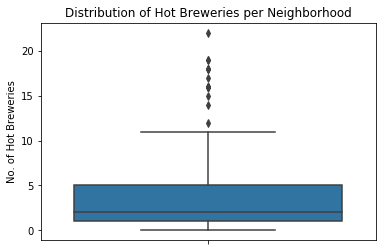

In [435]:
sns.boxplot(y='No. of Hot Breweries',data=tor_coffee_final)
plt.title('Distribution of Hot Breweries per Neighborhood')

Text(0.5, 1.0, 'Permits issued for Parks and Recreation vs No. of Hot Breweries')

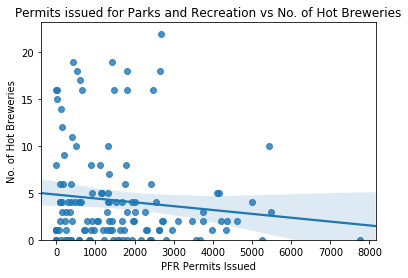

In [272]:
sns.regplot(x='PFR Permits Issued',y='No. of Hot Breweries',data=tor_coffee_final)
plt.ylim(0,)
plt.title('Permits issued for Parks and Recreation vs No. of Hot Breweries')

Text(0.5, 1.0, 'Crimes per week vs No. of Hot Breweries')

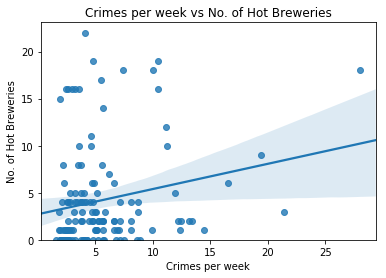

In [273]:
sns.regplot(x='Crimes per week',y='No. of Hot Breweries',data=tor_coffee_final)
plt.ylim(0,)
plt.title('Crimes per week vs No. of Hot Breweries')

Text(0.5, 1.0, 'Household Income vs No. of Hot Breweries')

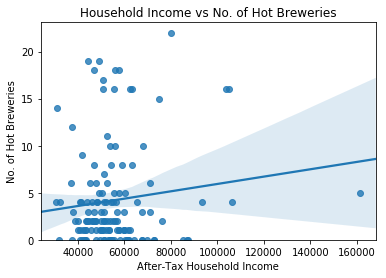

In [274]:
sns.regplot(x='After-Tax Household Income',y='No. of Hot Breweries',data=tor_coffee_final)
plt.ylim(0,)
plt.title('Household Income vs No. of Hot Breweries')

Text(0.5, 1.0, 'Potential Customers(age b/w 15 and 64) and Recreation vs No. of Hot Breweries')

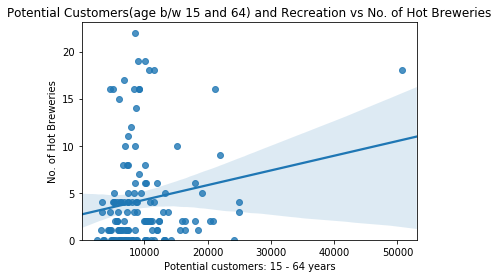

In [275]:
sns.regplot(x='Potential customers: 15 - 64 years',y='No. of Hot Breweries',data=tor_coffee_final)
plt.ylim(0,)
plt.title('Potential Customers(age b/w 15 and 64) and Recreation vs No. of Hot Breweries')

In [50]:
tor_coffee_final.corr()

,Neighbourhood Id,After-Tax Household Income,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,Potential customers: Employed,No. of Hot Breweries
Neighbourhood Id,1.000000,-0.063650,-0.024293,0.059116,0.097547,0.064290,-0.040797
After-Tax Household Income,-0.063650,1.000000,0.204600,-0.260229,-0.005475,0.104423,0.121016
PFR Permits Issued,-0.024293,0.204600,1.000000,0.126513,0.319577,0.272574,-0.112529
Crimes per week,0.059116,-0.260229,0.126513,1.000000,0.716731,0.595883,0.204758
Potential customers: 15 - 64 years,0.097547,-0.005475,0.319577,0.716731,1.000000,0.951749,0.172462
Potential customers: Employed,0.064290,0.104423,0.272574,0.595883,0.951749,1.000000,0.194100
No. of Hot Breweries,-0.040797,0.121016,-0.112529,0.204758,0.172462,0.194100,1.000000


### Normalising Features

In [640]:
norm_tc=pd.DataFrame()
norm_tc['Neighbourhood Name']=tor_coffee_final['Neighbourhood']
norm_tc['Neighbourhood Id']=tor_coffee_final['Neighbourhood Id']
norm_tc['Income']=(tor_coffee_final['After-Tax Household Income']-tor_coffee_final['After-Tax Household Income'].mean())/tor_coffee_final['After-Tax Household Income'].std()
norm_tc['Crime Rate']=(tor_coffee_final['Crimes per week']-tor_coffee_final['Crimes per week'].mean())/tor_coffee_final['Crimes per week'].std()
norm_tc['Potential Customers']=(tor_coffee_final['Potential customers: 15 - 64 years']-tor_coffee_final['Potential customers: 15 - 64 years'].mean())/tor_coffee_final['Potential customers: 15 - 64 years'].std()
norm_tc['PFR Permits Issued']=(tor_coffee_final['PFR Permits Issued']-tor_coffee_final['PFR Permits Issued'].mean())/tor_coffee_final['PFR Permits Issued'].std()

norm_tc.head()

,Neighbourhood Name,Neighbourhood Id,Income,Crime Rate,Potential Customers,PFR Permits Issued
0,West Humber-Clairville,1.0,0.265322,2.258470,1.056683,-0.113131
1,Mount Olive-Silverstone-Jamestown,2.0,-0.523664,1.130715,0.202682,0.175067
2,Thistletown-Beaumond Heights,3.0,0.130009,-0.768154,-0.896184,-0.248180
3,Rexdale-Kipling,4.0,-0.262592,-0.705501,-0.794950,-1.016011
4,Elms-Old Rexdale,5.0,-0.372344,-0.691042,-1.039816,0.585087


In [51]:
tor_coffee_final['Decision Metric']=((tor_coffee_final['After-Tax Household Income']+tor_coffee_final['Potential customers: 15 - 64 years'])-tor_coffee_final['Crimes per week'])/tor_coffee_final['PFR Permits Issued']
tor_coffee_final.head()

,Neighbourhood,Neighbourhood Id,After-Tax Household Income,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,Potential customers: Employed,No. of Hot Breweries,Decision Metric
0,West Humber-Clairville,1.0,59703.0,1385.0,14.500000,15695.0,10255.0,1.0,54.428520
1,Mount Olive-Silverstone-Jamestown,2.0,46986.0,1799.0,10.000000,10760.0,3225.0,18.0,32.093385
2,Thistletown-Beaumond Heights,3.0,57522.0,1191.0,2.423077,4410.0,2710.0,1.0,51.997966
3,Rexdale-Kipling,4.0,51194.0,88.0,2.673077,4995.0,3310.0,4.0,638.480988
4,Elms-Old Rexdale,5.0,49425.0,2388.0,2.730769,3580.0,1845.0,0.0,22.195255


In [52]:
tor_coffee_final['Normalized Decision Metric']=100*(tor_coffee_final['Decision Metric']-tor_coffee_final['Decision Metric'].min())/(tor_coffee_final['Decision Metric'].max()-tor_coffee_final['Decision Metric'].min())

In [53]:
tor_coffee_final['Normalized Decision Metric'].describe()

count    140.000000
mean       3.165563
std       13.137645
min        0.000000
25%        0.031838
50%        0.075341
75%        0.256702
max      100.000000
Name: Normalized Decision Metric, dtype: float64

In [54]:
tor_coffee_final['Verdict']=tor_coffee_final['Normalized Decision Metric']
for i in enumerate(tor_coffee_final['Normalized Decision Metric']):
    a=i[0]
    b=i[1]
    if b>0.14:
        tor_coffee_final.loc[a,'Verdict']='GOOD'
    elif (b<0.14) & (b>0.041):
        tor_coffee_final.loc[a,'Verdict']='AVERAGE'
    else:
        tor_coffee_final.loc[a,'Verdict']='BAD'

In [55]:
tor_coffee_final.drop(['Decision Metric'],axis=1,inplace=True)

In [56]:
tor_coffee_final.dropna(inplace=True)

In [57]:
tor_coffee_final.head(7)

,Neighbourhood,Neighbourhood Id,After-Tax Household Income,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,Potential customers: Employed,No. of Hot Breweries,Normalized Decision Metric,Verdict
0,West Humber-Clairville,1.0,59703.0,1385.0,14.500000,15695.0,10255.0,1.0,0.077503,AVERAGE
1,Mount Olive-Silverstone-Jamestown,2.0,46986.0,1799.0,10.000000,10760.0,3225.0,18.0,0.038302,BAD
2,Thistletown-Beaumond Heights,3.0,57522.0,1191.0,2.423077,4410.0,2710.0,1.0,0.073237,AVERAGE
3,Rexdale-Kipling,4.0,51194.0,88.0,2.673077,4995.0,3310.0,4.0,1.102573,GOOD
4,Elms-Old Rexdale,5.0,49425.0,2388.0,2.730769,3580.0,1845.0,0.0,0.020930,BAD
5,Kingsview Village-The Westway,6.0,50714.0,2.0,5.673077,7415.0,3505.0,1.0,50.988087,GOOD
6,Willowridge-Martingrove-Richview,7.0,57048.0,2711.0,5.596154,10200.0,7380.0,2.0,0.025508,BAD


In [58]:
#med=tor_coffee_final.median()
#med
temp1=tor_coffee_final[tor_coffee_final['Verdict']=='AVERAGE']
temp1.shape

(46, 10)

In [59]:
tor_coffee_final.shape

(136, 10)

<br>

## Part 6: Modelling

### Building a Logistic Regression Classification Model

In [60]:
Features=tor_coffee_final[['After-Tax Household Income','PFR Permits Issued','Crimes per week','Potential customers: 15 - 64 years','No. of Hot Breweries']]
y=tor_coffee_final['Verdict']

In [61]:
X=Features
X[0:5]

,After-Tax Household Income,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,No. of Hot Breweries
0,59703.0,1385.0,14.500000,15695.0,1.0
1,46986.0,1799.0,10.000000,10760.0,18.0
2,57522.0,1191.0,2.423077,4410.0,1.0
3,51194.0,88.0,2.673077,4995.0,4.0
4,49425.0,2388.0,2.730769,3580.0,0.0


In [62]:
y[0:5]

0    AVERAGE
1        BAD
2    AVERAGE
3       GOOD
4        BAD
Name: Verdict, dtype: object

In [63]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [64]:
X=preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.26387124, -0.10752647,  2.23804383,  1.04304696, -0.60731444],
       [-0.51784132,  0.18060271,  1.11634314,  0.19235297,  2.62796431],
       [ 0.12980542, -0.24254352, -0.77233237, -0.90225835, -0.60731444],
       [-0.25917603, -1.01019201, -0.71001567, -0.8014162 , -0.03638289],
       [-0.36791626,  0.59052561, -0.69563489, -1.04533353, -0.79762495]])

In [65]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=4)
print('Training Set:',X_train.shape,y_train.shape)
print('Testing Set:',X_test.shape,y_test.shape)

Training Set: (95, 5) (95,)
Testing Set: (41, 5) (41,)


In [66]:
decTree = DecisionTreeClassifier(criterion="entropy", max_depth = )
decTree 

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [67]:
decTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Testing and Evaluating the model

In [68]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

In [70]:
yhat_dt=decTree.predict(X_test)
print('Jaccard Similarity Index :',jaccard_similarity_score(y_test,yhat_dt))

Jaccard Similarity Index : 0.8536585365853658


In [71]:
print('F1 Score :',f1_score(y_test,yhat_dt,average='micro'))

F1 Score : 0.8536585365853658


### Deploying the Model

In [72]:
yhat=decTree.predict(X)
tor_coffee_final['Classified As']=yhat
tor_coffee_final.head(7)

,Neighbourhood,Neighbourhood Id,After-Tax Household Income,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,Potential customers: Employed,No. of Hot Breweries,Normalized Decision Metric,Verdict,Classified As
0,West Humber-Clairville,1.0,59703.0,1385.0,14.500000,15695.0,10255.0,1.0,0.077503,AVERAGE,AVERAGE
1,Mount Olive-Silverstone-Jamestown,2.0,46986.0,1799.0,10.000000,10760.0,3225.0,18.0,0.038302,BAD,BAD
2,Thistletown-Beaumond Heights,3.0,57522.0,1191.0,2.423077,4410.0,2710.0,1.0,0.073237,AVERAGE,AVERAGE
3,Rexdale-Kipling,4.0,51194.0,88.0,2.673077,4995.0,3310.0,4.0,1.102573,GOOD,GOOD
4,Elms-Old Rexdale,5.0,49425.0,2388.0,2.730769,3580.0,1845.0,0.0,0.020930,BAD,BAD
5,Kingsview Village-The Westway,6.0,50714.0,2.0,5.673077,7415.0,3505.0,1.0,50.988087,GOOD,GOOD
6,Willowridge-Martingrove-Richview,7.0,57048.0,2711.0,5.596154,10200.0,7380.0,2.0,0.025508,BAD,BAD


### Plotting the verdict on the map

In [73]:
tor_coffee_loc.head()

,Neighborhood,Neighborhood ID,Latitude,Longitude,No. of Hot Breweries
0,West Humber,1,43.680604,-79.482074,1.0
1,Mount Olive,2,43.653482,-79.383935,18.0
2,Silverstone,2,43.749751,-79.599116,0.0
3,Jamestown,2,43.653482,-79.383935,18.0
4,Thistletown,3,43.737266,-79.565317,1.0


In [74]:
tor_verdict=pd.DataFrame()
tor_verdict['Neighborhood ID']=tor_coffee_final['Neighbourhood Id']
tor_verdict['Verdict']=tor_coffee_final['Classified As']
tor_verdict.head()

,Neighborhood ID,Verdict
0,1.0,AVERAGE
1,2.0,BAD
2,3.0,AVERAGE
3,4.0,GOOD
4,5.0,BAD


In [75]:
tor_verdict.set_index('Neighborhood ID',inplace=True)

In [76]:
tor_plot=tor_coffee_loc.join(tor_verdict,on=['Neighborhood ID'],how='outer')

In [77]:
tor_plot['Verdict Bool']=tor_plot['Verdict'].replace(['GOOD','BAD','AVERAGE'],[1,0,2])
tor_plot.head()

,Neighborhood,Neighborhood ID,Latitude,Longitude,No. of Hot Breweries,Verdict,Verdict Bool
0,West Humber,1,43.680604,-79.482074,1.0,AVERAGE,2
1,Mount Olive,2,43.653482,-79.383935,18.0,BAD,0
2,Silverstone,2,43.749751,-79.599116,0.0,BAD,0
3,Jamestown,2,43.653482,-79.383935,18.0,BAD,0
4,Thistletown,3,43.737266,-79.565317,1.0,AVERAGE,2


In [78]:
# create map
map_verdict = folium.Map(location=[lat_tor, long_tor], zoom_start=11)

# set color scheme for the clusters
x = np.arange(2)
ys = [i + x + (i*x)**2 for i in range(2)]
rainbow = ['red','green','orange']

# add markers to the map
markers_colors = []
for lat, lon, poi, verdict in zip(tor_plot['Latitude'], tor_plot['Longitude'], tor_plot['Neighborhood'], tor_plot['Verdict Bool']):
    label = folium.Popup(str(poi) + ' Verdict: ' + str(verdict), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[verdict],
        fill=True,
        fill_color=rainbow[verdict],
        fill_opacity=0.7).add_to(map_verdict)
       
map_verdict

In [79]:
tor_coffee_final.drop(['Verdict'],axis=1,inplace=True)

In [80]:
tor_coffee_final.head()

,Neighbourhood,Neighbourhood Id,After-Tax Household Income,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,Potential customers: Employed,No. of Hot Breweries,Normalized Decision Metric,Classified As
0,West Humber-Clairville,1.0,59703.0,1385.0,14.500000,15695.0,10255.0,1.0,0.077503,AVERAGE
1,Mount Olive-Silverstone-Jamestown,2.0,46986.0,1799.0,10.000000,10760.0,3225.0,18.0,0.038302,BAD
2,Thistletown-Beaumond Heights,3.0,57522.0,1191.0,2.423077,4410.0,2710.0,1.0,0.073237,AVERAGE
3,Rexdale-Kipling,4.0,51194.0,88.0,2.673077,4995.0,3310.0,4.0,1.102573,GOOD
4,Elms-Old Rexdale,5.0,49425.0,2388.0,2.730769,3580.0,1845.0,0.0,0.020930,BAD


In [86]:
tor_class=tor_coffee_final[['Neighbourhood Id','After-Tax Household Income','PFR Permits Issued','Crimes per week','Potential customers: 15 - 64 years', 'No. of Hot Breweries','Classified As']]
tor_class.head()

,Neighbourhood Id,After-Tax Household Income,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,No. of Hot Breweries,Classified As
0,1.0,59703.0,1385.0,14.500000,15695.0,1.0,AVERAGE
1,2.0,46986.0,1799.0,10.000000,10760.0,18.0,BAD
2,3.0,57522.0,1191.0,2.423077,4410.0,1.0,AVERAGE
3,4.0,51194.0,88.0,2.673077,4995.0,4.0,GOOD
4,5.0,49425.0,2388.0,2.730769,3580.0,0.0,BAD


In [89]:
tor_class_grp=tor_class.groupby(['Classified As'],as_index=False).median()
tor_class_grp

,Classified As,Neighbourhood Id,After-Tax Household Income,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,No. of Hot Breweries
0,AVERAGE,74.5,55609.5,1323.5,4.144231,8050.0,2.0
1,BAD,52.0,51247.0,2636.0,5.173077,10830.0,2.0
2,GOOD,76.0,51381.0,243.0,3.557692,6850.0,3.0


In [91]:
tor_good=tor_coffee_final[tor_coffee_final['Classified As']=='GOOD']
tor_good.head()

,Neighbourhood,Neighbourhood Id,After-Tax Household Income,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,Potential customers: Employed,No. of Hot Breweries,Normalized Decision Metric,Classified As
3,Rexdale-Kipling,4.0,51194.0,88.0,2.673077,4995.0,3310.0,4.0,1.102573,GOOD
5,Kingsview Village-The Westway,6.0,50714.0,2.0,5.673077,7415.0,3505.0,1.0,50.988087,GOOD
7,Humber Heights-Westmount,8.0,54919.0,231.0,2.057692,4665.0,3335.0,0.0,0.434669,GOOD
9,Princess-Rosethorn,10.0,93391.0,643.0,2.826923,6300.0,4925.0,4.0,0.254079,GOOD
11,Markland Wood,12.0,64297.0,372.0,1.615385,5515.0,4455.0,0.0,0.311341,GOOD


In [93]:
tor_good.shape

(49, 10)

In [95]:
tor_good.describe()

,Neighbourhood Id,After-Tax Household Income,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,Potential customers: Employed,No. of Hot Breweries,Normalized Decision Metric
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,72.530612,52524.959184,258.326531,4.978022,7601.734694,5375.000000,5.061224,8.943042
std,35.443089,12052.593720,206.019658,4.311999,3568.920610,2982.324841,5.921037,21.151447
min,4.000000,31304.000000,1.000000,1.615385,2570.000000,260.000000,0.000000,0.113664
25%,57.000000,45058.000000,90.000000,2.423077,5420.000000,3675.000000,0.000000,0.215106
50%,76.000000,51381.000000,243.000000,3.557692,6850.000000,4925.000000,3.000000,0.442106
75%,97.000000,55536.000000,374.000000,5.096154,8790.000000,6700.000000,8.000000,1.102573
max,138.000000,93391.000000,713.000000,21.442308,21920.000000,16695.000000,19.000000,100.000000


In [96]:
tor_avg=tor_coffee_final[tor_coffee_final['Classified As']=='AVERAGE']
tor_avg.head()

,Neighbourhood,Neighbourhood Id,After-Tax Household Income,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,Potential customers: Employed,No. of Hot Breweries,Normalized Decision Metric,Classified As
0,West Humber-Clairville,1.0,59703.0,1385.0,14.500000,15695.0,10255.0,1.0,0.077503,AVERAGE
2,Thistletown-Beaumond Heights,3.0,57522.0,1191.0,2.423077,4410.0,2710.0,1.0,0.073237,AVERAGE
8,Edenbridge-Humber Valley,9.0,62463.0,1294.0,2.653846,8465.0,6760.0,1.0,0.078174,AVERAGE
13,Islington-City Centre West,14.0,57658.0,1138.0,11.961538,19140.0,14075.0,5.0,0.100400,AVERAGE
14,Kingsway South,15.0,106386.0,1314.0,2.096154,5220.0,4320.0,4.0,0.131044,AVERAGE


In [98]:
tor_avg.shape

(42, 10)

In [99]:
tor_avg.describe()

,Neighbourhood Id,After-Tax Household Income,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,Potential customers: Employed,No. of Hot Breweries,Normalized Decision Metric
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,72.500000,59925.023810,1391.214286,5.803114,10478.571429,7211.666667,4.166667,0.076294
std,43.002694,22838.181135,598.281585,4.689394,8297.452980,7152.246080,4.948105,0.026478
min,1.000000,30794.000000,590.000000,2.019231,3290.000000,510.000000,0.000000,0.033136
25%,33.000000,47637.250000,1056.500000,2.846154,6270.000000,3736.250000,1.000000,0.053884
50%,74.500000,55609.500000,1323.500000,4.144231,8050.000000,5757.500000,2.000000,0.074189
75%,110.000000,61637.500000,1547.000000,7.139423,10305.000000,7317.500000,5.000000,0.092806
max,140.000000,161448.000000,4105.000000,28.057692,50645.000000,44110.000000,19.000000,0.131044


In [100]:
tor_bad=tor_coffee_final[tor_coffee_final['Classified As']=='BAD']
tor_bad.head()

,Neighbourhood,Neighbourhood Id,After-Tax Household Income,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,Potential customers: Employed,No. of Hot Breweries,Normalized Decision Metric,Classified As
1,Mount Olive-Silverstone-Jamestown,2.0,46986.0,1799.0,10.000000,10760.0,3225.0,18.0,0.038302,BAD
4,Elms-Old Rexdale,5.0,49425.0,2388.0,2.730769,3580.0,1845.0,0.0,0.020930,BAD
6,Willowridge-Martingrove-Richview,7.0,57048.0,2711.0,5.596154,10200.0,7380.0,2.0,0.025508,BAD
10,Eringate-Centennial-West Deane,11.0,69740.0,7770.0,3.269231,10060.0,7975.0,0.0,0.000000,BAD
12,Etobicoke West Mall,13.0,50570.0,2311.0,1.826923,6070.0,4400.0,1.0,0.024990,BAD


In [101]:
tor_bad.shape

(45, 10)

In [102]:
tor_bad.describe()

,Neighbourhood Id,After-Tax Household Income,PFR Permits Issued,Crimes per week,Potential customers: 15 - 64 years,Potential customers: Employed,No. of Hot Breweries,Normalized Decision Metric
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,65.600000,54338.400000,3072.955556,5.850427,11089.266667,7391.155556,3.266667,0.024090
std,43.809712,11984.226371,1321.992091,2.907904,4304.028754,3531.268391,4.750120,0.014485
min,2.000000,32539.000000,1342.000000,1.826923,3580.000000,1360.000000,0.000000,0.000000
25%,34.000000,46803.000000,2025.000000,4.000000,7495.000000,5400.000000,1.000000,0.013861
50%,52.000000,51247.000000,2636.000000,5.173077,10830.000000,6865.000000,2.000000,0.023618
75%,104.000000,60065.000000,3748.000000,6.846154,13035.000000,9750.000000,4.000000,0.031317
max,137.000000,86816.000000,7770.000000,13.173077,21235.000000,16770.000000,22.000000,0.066989
